# Import FreeSurfer Subjects Directory Into Mindcontrol
This work flow reads the SUBJECTS_DIR variable, converts all volumetric data from .mgz into .nii.

## Import necessary packages

In [1]:
import os
import os.path as op
import nibabel as nb
from glob import glob
from IPython.display import Image
from nipype import MapNode, Workflow, Node
from nipype.interfaces.freesurfer import MRIConvert
from nipype.interfaces.io import DataSink
from nipype.interfaces.utility import IdentityInterface, Function
from IPython.display import Image

ImportError: No module named 'nibabel'

## Inputs and Outputs

In [2]:
# Set SUBJECTS_DIR, if not set already 
os.environ["SUBJECTS_DIR"] = "/home/ltirrell/data/mindcontrol"
subjects_dir = os.environ["SUBJECTS_DIR"]

# Set Mindcontrol output directory
mindcontrol_outdir = "/home/ltirrell/projects/mindcontrol/base_dir"

# Select subjects to prepare (this will do all inside the SUBJECTS_DIR)
subject_paths = glob(op.join(subjects_dir, "*"))

# SUBJECTS_DIR sometimes contains directories that aren't subjects, don't grab them

subjects = []
for path in subject_paths:
    subject = path.split('/')[-1]
    # check if mri dir exists, and don't add fsaverage
    if op.exists(op.join(path, 'mri')) and subject != 'fsaverage':
        subjects.append(subject)


# Volumes that will be prepared
volumes = ["brainmask.mgz", "wm.mgz", "aparc+aseg.mgz", "T1.mgz"]

## Helper functions

In [3]:
def data_grabber(subjects_dir, subject, volumes):
    import os
    volumes_list = [os.path.join(subjects_dir, subject, 'mri', volume) for volume in volumes]
    return volumes_list

## Nodes

In [4]:
input_node = Node(IdentityInterface(fields=['subject_id']), name='inputnode')
input_node.iterables=("subject_id", subjects)


dg_node=Node(Function(input_names=["subjects_dir", "subject", "volumes"],
                      output_names=["volume_paths"], 
                      function=data_grabber), 
             name="datagrab")
dg_node.inputs.subjects_dir = subjects_dir
dg_node.inputs.volumes = volumes


mriconvert_node = MapNode(MRIConvert(out_type="niigz"), 
                          iterfield=["in_file"], 
                          name='convert')


datasink_node = Node(DataSink(base_directory=mindcontrol_outdir),
                     name='datasink')
subst = [('out_file',''),('_subject_id_',''),('_out','')]  + [("_convert%d" % index, "") for index in range(len(volumes))] 
datasink_node.inputs.substitutions = subst

## Workflow

In [5]:
wf = Workflow(name="MindPrepFS")
wf.base_dir = "/home/ltirrell/projects/mindcontrol/scratch"
wf.connect(input_node,"subject_id", dg_node,"subject")
wf.connect(dg_node,"volume_paths", mriconvert_node, "in_file")
wf.connect(mriconvert_node,'out_file',datasink_node,'out_file')
wf.write_graph(graph2use='exec')

wf.run()

170404-10:56:42,364 workflow INFO:
	 Creating detailed dot file: /home/ltirrell/projects/mindcontrol/scratch/MindPrepFS/graph_detailed.dot
170404-10:56:42,495 workflow INFO:
	 Creating dot file: /home/ltirrell/projects/mindcontrol/scratch/MindPrepFS/graph.dot
170404-10:56:42,578 workflow INFO:
	 Workflow MindPrepFS settings: ['check', 'execution', 'logging']
170404-10:56:42,597 workflow INFO:
	 Running serially.
170404-10:56:42,598 workflow INFO:
	 Executing node datagrab.a1 in dir: /home/ltirrell/projects/mindcontrol/scratch/MindPrepFS/_subject_id_sub-01/datagrab
170404-10:56:42,602 workflow INFO:
170404-10:56:42,612 workflow INFO:
	 Executing node convert.a1 in dir: /home/ltirrell/projects/mindcontrol/scratch/MindPrepFS/_subject_id_sub-01/convert
170404-10:56:42,623 workflow INFO:
	 Executing node datasink.a1 in dir: /home/ltirrell/projects/mindcontrol/scratch/MindPrepFS/_subject_id_sub-01/datasink
170404-10:56:42,755 interface INFO:
	 sub: /home/ltirrell/projects/mindcontrol/base_di

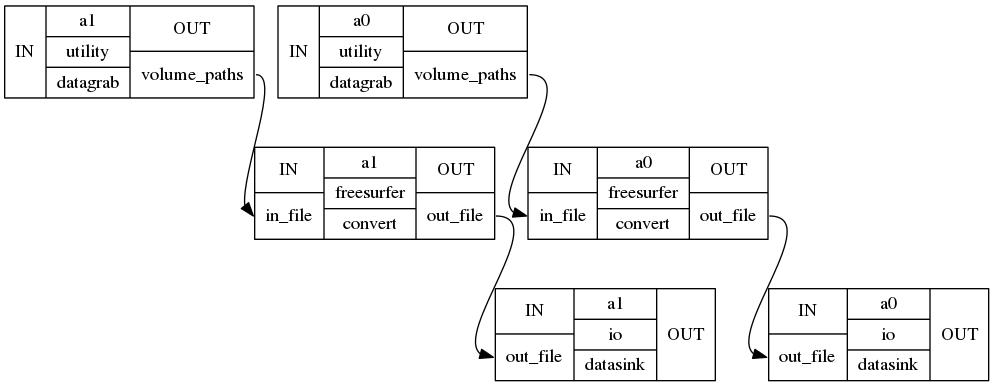

In [6]:
Image('/home/ltirrell/projects/mindcontrol/scratch/MindPrepFS/graph_detailed.dot.png')